# Learning an Epitrochoid with a Running Mean

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GalacticDynamics/localflowwalk/blob/main/docs/tutorials/epitrochoid_runningmean.ipynb)

In [1]:
import jax
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np

import quaxed.numpy as jnp
import unxt as u

import phasecurvefit as pcf

In [2]:
key = jr.key(201030)

## Data: Self-Intersecting Epitrochoid Curve

We build a single stream that self-intersects using an **epitrochoid curve** that traces one continuous loop from 5° to 355°, leaving a 10° gap so the curve doesn't close back on itself. The epitrochoid's internal structure (5 loops within one outer rotation) creates multiple self-intersections along the path.

At the crossings, a pure distance-based walk (`lam=0`) can jump to the other branch. The momentum term (`lam>0`) biases toward continuing along the current direction, dramatically reducing branch-jumps.

We parameterize the stream by a scalar `t`, and evaluate ordering quality by counting non-monotonic steps in `t` along the walked path (backward jumps).

In [3]:
usys = u.unitsystems.si

In [4]:
def make_self_intersecting_stream(
    key,
    *,
    n: int,
    noise_sigma=0.5,
    scale=120.0,
    R: float = 5.0,
    r: float = 1.0,
    d: float = 4.5,
):
    """Return (pos, vel, t) for an OPEN curve with self-intersections."""
    # Epitrochoid parameters: ratio=5 means 5 internal loops per outer rotation

    # Single outer rotation: 5° to 355° with 10° gap
    t_start = 5.0 * jnp.pi / 180.0
    t_end = 355.0 * jnp.pi / 180.0
    t = jnp.linspace(t_start, t_end, n)

    ratio = (R + r) / r  # = 5 internal rotations per outer rotation
    x0 = scale * ((R + r) * jnp.cos(t) - d * jnp.cos(ratio * t)) / 5.0
    y0 = scale * ((R + r) * jnp.sin(t) - d * jnp.sin(ratio * t)) / 5.0

    # Derivatives for velocity
    dx0 = scale * (-(R + r) * jnp.sin(t) + d * ratio * jnp.sin(ratio * t)) / 5.0
    dy0 = scale * ((R + r) * jnp.cos(t) - d * ratio * jnp.cos(ratio * t)) / 5.0

    # Optional small positional noise
    kx, ky = jax.random.split(key)
    x = x0 + noise_sigma * jax.random.normal(kx, (n,))
    y = y0 + noise_sigma * jax.random.normal(ky, (n,))

    # Pack into unitful quantities
    pos = {"x": u.Q(x, usys["length"]), "y": u.Q(y, usys["length"])}
    vel = {"x": u.Q(dx0, usys["speed"]), "y": u.Q(dy0, usys["speed"])}
    return t, pos, vel

In [5]:
key, subkey = jax.random.split(key)
t, pos, vel = make_self_intersecting_stream(
    subkey,
    n=2048,
    noise_sigma=6,
)

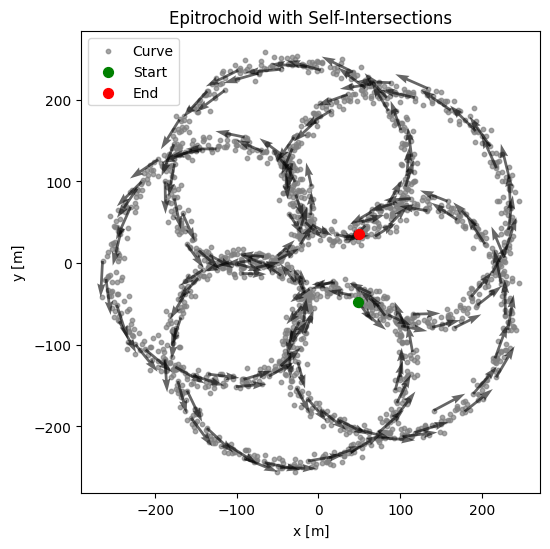

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(pos["x"], pos["y"], label="Curve", color="gray", alpha=0.7, s=10)

# Add velocity arrows every 10th point
every = 12
ax.quiver(
    np.array(pos["x"][::every]),
    np.array(pos["y"][::every]),
    np.array(vel["x"][::every]),
    np.array(vel["y"][::every]),
    scale=10_000,
    width=0.006,
    alpha=0.6,
    color="black",
)

ax.scatter(pos["x"][:1], pos["y"][:1], label="Start", color="green", s=50)
ax.scatter(pos["x"][-1:], pos["y"][-1:], label="End", color="red", s=50)
ax.legend()
ax.set(
    aspect="equal",
    title="Epitrochoid with Self-Intersections",
    xlabel=f"x [{ax.get_xlabel()}]",
    ylabel=f"y [{ax.get_ylabel()}]",
)
plt.show();

In [7]:
# Shuffle the data
key, subkey = jr.split(key)
order = jr.permutation(subkey, jnp.arange(len(t)))

qs = jax.tree.map(lambda x: x[order], pos)
ps = jax.tree.map(lambda x: x[order], vel)

In [8]:
# Determine the starting index as the point closest to the starting point
start_idx = int(np.argsort(order)[0])

# Walk configuration
config = pcf.WalkConfig(
    strategy=pcf.strats.KDTree(k=60),
    metric=pcf.metrics.FullPhaseSpaceDistanceMetric(),
)
metric_scale = u.Q(4, "s")
max_dist = u.Q(40, "m")

# Perform walk
walkresult = pcf.walk_local_flow(
    qs,
    ps,
    start_idx=start_idx,
    metric_scale=metric_scale,
    max_dist=max_dist,
    config=config,
    direction="forward",
    metadata=pcf.StateMetadata(usys=usys),
)

# Train encoder & apply running mean function
key, model_key, train_key = jr.split(key, 3)
normalizer = pcf.nn.StandardScalerNormalizer(qs, ps)
model = pcf.nn.EncoderExternalDecoder(
    encoder=pcf.nn.OrderingNet(in_size=4, key=model_key),
    decoder=pcf.nn.RunningMeanDecoder(window_size=0.05),
    normalizer=normalizer,
)
result, opt_state, losses = pcf.nn.train_autoencoder(model, walkresult, key=train_key)

Training:   0%|          | 0/800 [00:00<?, ?epoch/s]

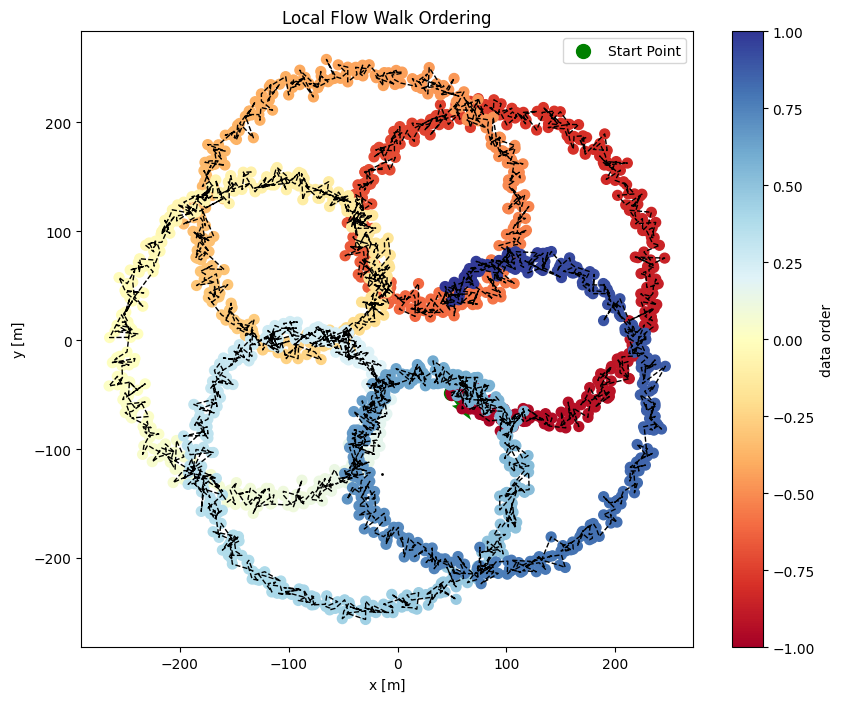

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
im = ax.scatter(qs["x"], qs["y"], s=1, c="k")

ax.scatter(
    np.array(qs["x"][start_idx])[None],
    np.array(qs["y"][start_idx])[None],
    c="green",
    s=100,
    label="Start Point",
)
ax.quiver(
    np.array(qs["x"][start_idx])[None],
    np.array(qs["y"][start_idx])[None],
    np.array(ps["x"][start_idx])[None],
    np.array(ps["y"][start_idx])[None],
    color="green",
)

ordering = walkresult.ordering
walk_qs = {k: v[ordering] for k, v in walkresult.positions.items()}
timeline = np.linspace(-1, 1, len(ordering))
im = ax.scatter(walk_qs["x"], walk_qs["y"], s=50, c=timeline, cmap="RdYlBu")
ax.plot(walk_qs["x"], walk_qs["y"], c="k", lw=1, ls="--")

plt.colorbar(im, ax=ax, label="data order")

ax.set(
    aspect="equal",
    xlabel=f"x [{ax.get_xlabel()}]",
    ylabel=f"y [{ax.get_ylabel()}]",
    title="Local Flow Walk Ordering",
)
plt.legend()
plt.show();

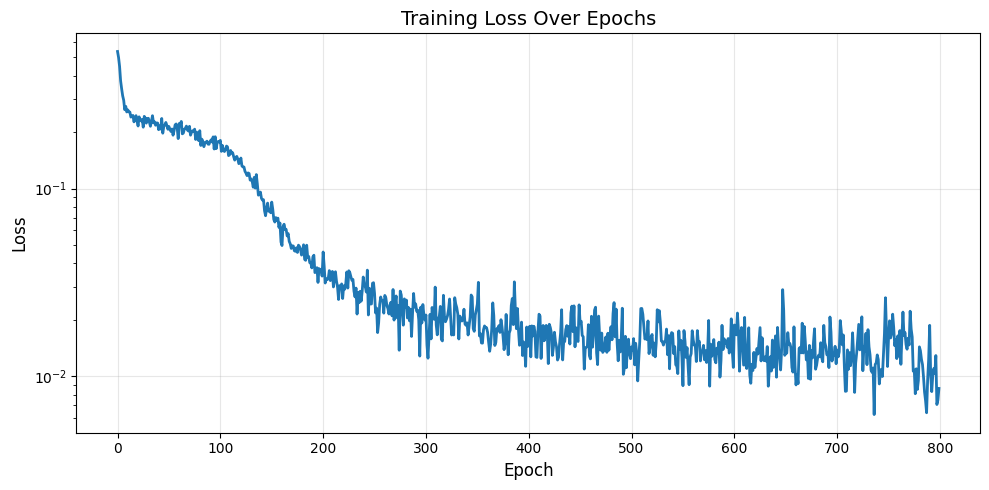

Final loss: 0.008617


In [10]:
# Plot training losses
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(np.asarray(losses), linewidth=2)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.set_title("Training Loss Over Epochs", fontsize=14)
ax.set_yscale("log")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f"Final loss: {losses[-1]:.6f}")

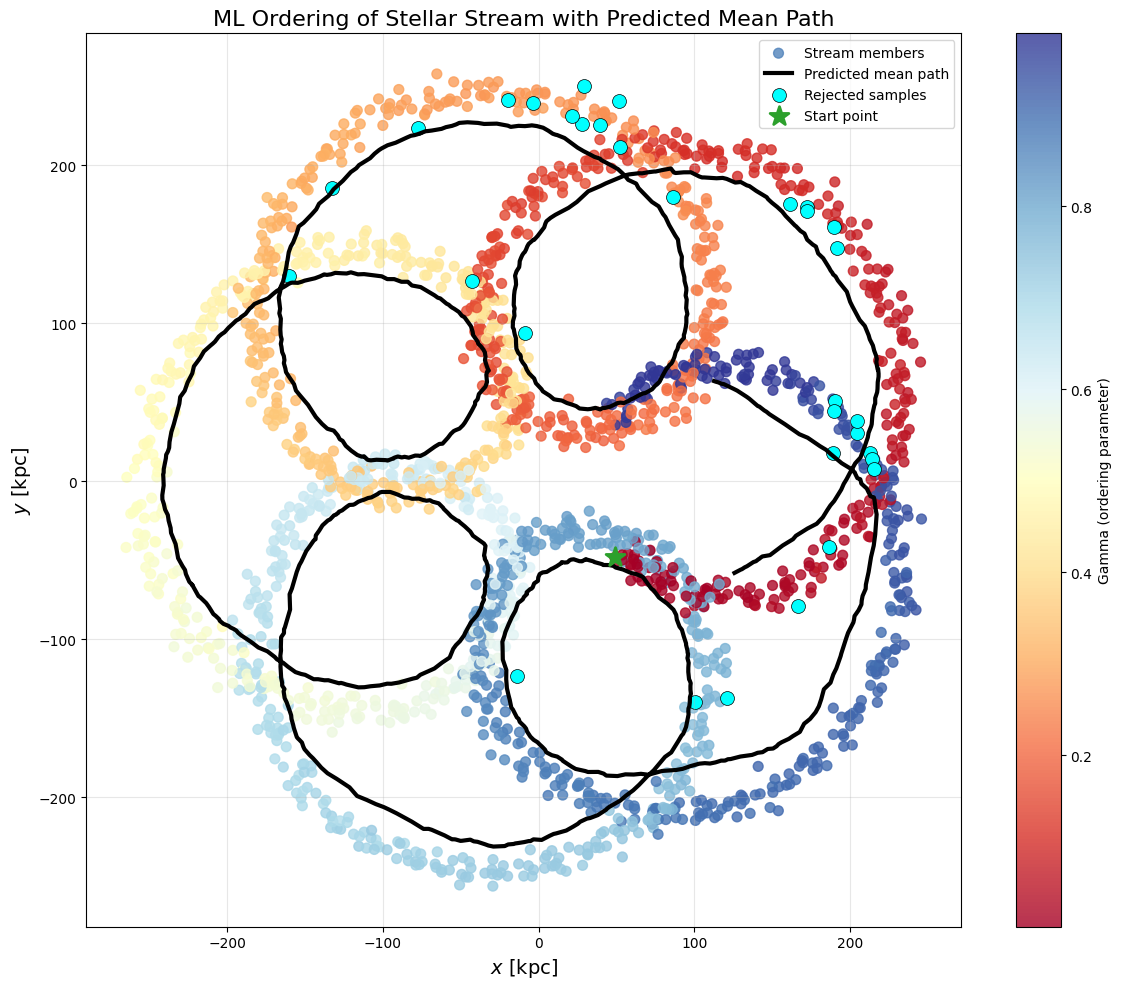

In [11]:
# Visualize the ML-filled path in 2D with mean path prediction
fig, ax = plt.subplots(figsize=(12, 10))

# all_gamma, all_probs = jax.vmap(model.encoder)(all_ws)
all_gamma, all_probs = result.model.encode(result.positions, result.velocities)
rejected_membership = all_probs < 0.9
qs_pred = result(jnp.linspace(0.02, 0.98, 1_000))

# Plot all points with gradient coloring
im = ax.scatter(
    np.asarray(qs["x"]),
    np.asarray(qs["y"]),
    s=50,
    c=np.asarray(all_gamma),
    cmap="RdYlBu",
    alpha=0.8,
    label="Stream members",
)

# Plot predicted mean path
ax.plot(
    np.asarray(qs_pred["x"]),
    np.asarray(qs_pred["y"]),
    c="k",
    lw=3,
    label="Predicted mean path",
)

# Mark rejected samples in cyan
ax.scatter(
    np.asarray(qs["x"][rejected_membership]),
    np.asarray(qs["y"][rejected_membership]),
    s=100,
    c="cyan",
    alpha=1.0,
    marker="o",
    edgecolors="black",
    linewidths=0.5,
    label="Rejected samples",
)

# Mark start point
ax.scatter(
    np.asarray(qs["x"][start_idx]),
    np.asarray(qs["y"][start_idx]),
    s=200,
    c="tab:green",
    marker="*",
    label="Start point",
    linewidths=2,
    zorder=5,
)

ax.set_xlabel(r"$x$ [kpc]", fontsize=14)
ax.set_ylabel(r"$y$ [kpc]", fontsize=14)
ax.set_title("ML Ordering of Stellar Stream with Predicted Mean Path", fontsize=16)
fig.colorbar(im, ax=ax, label="Gamma (ordering parameter)")
ax.legend(loc="upper right", fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show();